# Лабараторная работа 1

## Часть 1 - сбор данных

Используемый сайт:
https://ngs24.ru/

Cохраняются следующие сущности
1. title - заголовок статьи
2. content - текст статьи
3. category - категория статьи
4. created_date - дата создания статьи (при наличии)

Парсер основанный на асинхронности (вариант 3)

Формат хранения результатов
.sqlite3

Файл с данными:
[test.db](/test.db)

## Часть 2 - анализ текстовых данных

Провести аналитику текстовых данных.

1. Токенезировать и лемматизировать полученные текстовые данные полученные из 1 части задания

- Токенизация - разделение слов на предложения
- Лемматизация - перевод слов в начальную форму

2. Посчитать наиболее встречающиеся пары подлежащих и сказуемых
3. Посчитать самые популлярные слова (исключая стоп-слова, словарь стоп слов можно найти в nltk, либо отбросить по частям речи)
4. Вывести статистику (по убыванию, наиболее встречающеся пары и самые популярные слова за исключением стоп-слов)

In [1]:
import sqlite3
from ipymarkup import show_dep_ascii_markup as show_markup

from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,
    NamesExtractor,

    Doc
)

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/kiwi_kam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# подключается и берем титульник и тело
conn = sqlite3.connect('test.db')
cur = conn.cursor()

headers = cur.execute('''select title from test limit 300''').fetchall()
bodies = cur.execute('''select body from test limit 300''').fetchall()

# делаем для обработки
data = dict(zip(headers, bodies))
text = list(data.values())
print(f'Количество строк: {len(text)}')

doc = Doc(str(text))

Количество строк: 300


In [3]:
doc.segment(segmenter)
doc.parse_syntax(syntax_parser)

In [4]:
doc.tag_morph(morph_tagger)

In [5]:
for sentence in doc.sents[0:299]: # получаем предложения
    sentence.syntax.print()

┌────────────────────────────► [               punct
│                       ┌────► (               punct
│                       │ ┌──► '               punct
│                       │ │ ┌► Он              nsubj
│           ┌─┌─┌─┌─┌───└─└─└─ считает         
│           │ │ │ │ │ ┌──────► ,               punct
│           │ │ │ │ │ │ ┌────► что             mark
│           │ │ │ │ │ │ │   ┌► в               case
│           │ │ │ │ │ │ │ ┌►└─ деле            obl
│           │ │ │ │ └►└─└─└─── нет             ccomp
│           │ │ │ │     │   ┌► никакого        det
│           │ │ │ │     └──►└─ криминала       nsubj
│           │ │ │ └──────────► \               punct
│           │ │ └────────────► n               obl
│           │ └──────────────► Источник        ccomp
│           │               ┌► :               punct
│ ┌─┌─┌─────└──►┌───────┌─┌─└─ Министерство    nsubj
│ │ │ │         │       │ └──► здравоохранения nmod
│ │ │ │         │       │   ┌► Красноярского   amod
│ │ │ │ 

In [ ]:
for sentence in doc.sents:
    for token in sentence.tokens: # получаем токены
        print(token)

In [8]:
# лемматизация
for sent in doc.sents:
  for token in sent.tokens:
    token.lemmatize(morph_vocab)
  print({_.text: _.lemma for _ in sent.tokens})

{'[': '[', '(': '(', "'": "'", 'Он': 'он', 'считает': 'считать', ',': ',', 'что': 'что', 'в': 'в', 'деле': 'дело', 'нет': 'нет', 'никакого': 'никакой', 'криминала': 'криминал', '\\': '\\', 'n': 'n', 'Источник': 'источник', ':': ':', 'Министерство': 'министерство', 'здравоохранения': 'здравоохранение', 'Красноярского': 'красноярский', 'края': 'край', '/': '/', 'krasnoyarsk': 'krasnoyarsk', '.': '.', 'dk': 'dk', 'ru': 'ru', 'Артем': 'артем', 'Ленц': 'ленц', 'NGS': 'ngs', '24': '24', 'RU': 'ru', 'Защитник': 'защитник', 'бывшей': 'бывший', 'замминистра': 'замминистра', 'Минздрава': 'минздрав', 'Анны': 'анна', 'Москвиной': 'москвин', 'Эдуард': 'эдуард', 'Клейман': 'клейман', 'поделился': 'поделиться', 'мнением': 'мнение', 'о': 'о', 'ее': 'ее', 'задержании': 'задержание'}
{'Бывшую': 'бывший', 'чиновницу': 'чиновница', 'обвиняют': 'обвинять', 'в': 'в', 'превышении': 'превышение', 'должностных': 'должностной', 'полномочий': 'полномочие', 'при': 'при', 'поставке': 'поставка', 'медоборудования':

In [9]:
all_pairs = []

for sentence in doc.sents:
  nsubj = ''
  root = ''
  for token in sentence.tokens:
    token.lemmatize(morph_vocab)

    if token.rel == "nsubj":
      nsubj = token.lemma
    if token.rel == 'root':
      root = token.lemma
    if nsubj and root:
      all_pairs.append((nsubj, root))

In [10]:
from collections import Counter


pairs_count = Counter(all_pairs)
pairs_count

Counter({('мы', 'рассказывать'): 459,
         ('который', 'быть'): 280,
         ('мероприятие', 'закрыть'): 280,
         ('он', 'мочь'): 271,
         ('тема', 'подписываться'): 268,
         ('источник', 'подписываться'): 231,
         ('вы', 'мочь'): 209,
         ('речь', 'идти'): 207,
         ('я', 'сказать'): 201,
         ('я', 'хотеть'): 199,
         ('человек', 'мочь'): 180,
         ('он', 'стать'): 172,
         ('он', 'считать'): 167,
         ('нгс', 'новость'): 162,
         ('больше', 'новость'): 156,
         ('\\', 'подписываться'): 154,
         ('это', 'мочь'): 142,
         ('мария', 'показывать'): 137,
         ('он', 'должный'): 136,
         ('мы', 'следить'): 133,
         ('который', 'прописать'): 133,
         ('\\', 'быть'): 123,
         ('он', 'быть'): 123,
         ('он', 'рассказать'): 122,
         ('я', 'стать'): 119,
         ('я', 'мочь'): 115,
         ('цена', 'стартовать'): 114,
         ('источник', 'нужный'): 113,
         ('они', 'мочь'): 11

In [11]:
pairs_count.most_common(10)

[(('мы', 'рассказывать'), 459),
 (('который', 'быть'), 280),
 (('мероприятие', 'закрыть'), 280),
 (('он', 'мочь'), 271),
 (('тема', 'подписываться'), 268),
 (('источник', 'подписываться'), 231),
 (('вы', 'мочь'), 209),
 (('речь', 'идти'), 207),
 (('я', 'сказать'), 201),
 (('я', 'хотеть'), 199)]

Так как получение данных было на начало мая, то в топ попал "мероприятие, закрыть". Так же "тема, подписываться" и "источник, подписываться" - это больше относится к обращению вне статьи, где читатеям предлагают подписаться на другие источники новостного проекта (сайта).

In [12]:
filtered = []
punct = ['(', ')', ',', '.', '?', '!', '«', '»', '—', '"', ':', ';', '-', '–', '\\', '1', '2', '3', '4', '5', '6', '7', '9', '0', 'n', 'xa', "'", 'n—', '/', 'ru', '24', '051', '034', 'ntrillium', '048', '+', 'ngs','t', 'me', '049']

for sentence in doc.sents:
  for token in sentence.tokens:
    token.lemmatize(morph_vocab)
    if token.lemma not in stop_words and token.lemma not in punct:
      filtered.append(token.lemma)

In [13]:
words_count = Counter(filtered)
words_count.most_common(100)

[('это', 1157),
 ('год', 985),
 ('источник', 981),
 ('который', 874),
 ('весь', 849),
 ('человек', 654),
 ('мочь', 532),
 ('свой', 517),
 ('наш', 397),
 ('красноярск', 378),
 ('первый', 376),
 ('рубль', 376),
 ('стать', 356),
 ('новость', 344),
 ('ребенок', 329),
 ('день', 326),
 ('тема', 324),
 ('также', 311),
 ('ната', 300),
 ('леонов', 300),
 ('время', 287),
 ('работа', 281),
 ('говорить', 270),
 ('дом', 269),
 ('новый', 265),
 ('нужный', 249),
 ('дело', 247),
 ('рассказать', 240),
 ('май', 235),
 ('тысяча', 234),
 ('россия', 230),
 ('рф', 224),
 ('работать', 224),
 ('рассказывать', 207),
 ('очень', 202),
 ('место', 201),
 ('слово', 199),
 ('сказать', 192),
 ('жизнь', 186),
 ('важный', 178),
 ('должный', 177),
 ('группа', 173),
 ('министр', 170),
 ('женщина', 168),
 ('город', 164),
 ('самый', 162),
 ('вопрос', 158),
 ('хотеть', 158),
 ('семья', 156),
 ('компания', 156),
 ('область', 153),
 ('получить', 152),
 ('просто', 151),
 ('несколько', 150),
 ('девушка', 149),
 ('телеграм-канал

In [14]:
print(len(words_count))

15365


Вопрос по стоп-словам остается открытым, "это" можно тоже отфильтровать и так далее, но это лишает прописанного алгоритма и делает выборочный отбор. Однако после фильтрации осталось 15365 слов.

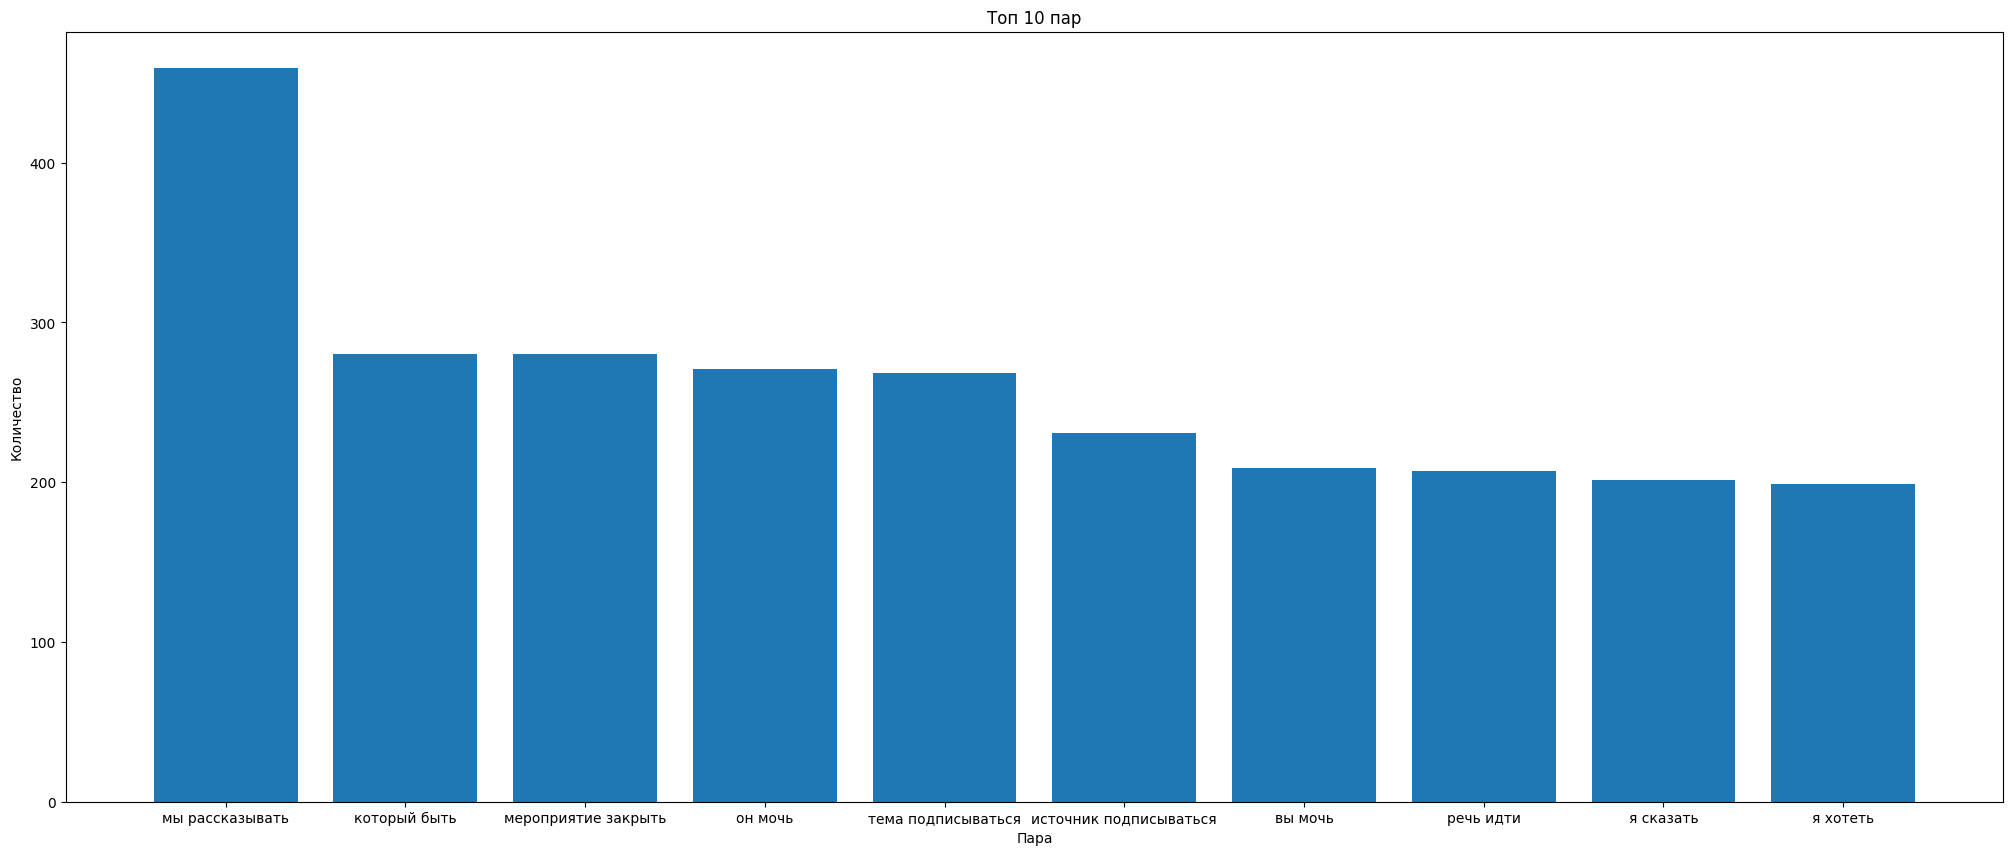

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
df = DataFrame()
pair = [(i[0][0] + ' ' + i[0][1]) for i in pairs_count.most_common(10)]
count = [i[1] for i in pairs_count.most_common(10)]

df["Pair"] = pair
df["Count"] = count
fig, ax = plt.subplots(figsize=(25, 10))

plt.bar(df["Pair"], df["Count"])
plt.title("Топ 10 пар")
plt.ylabel("Количество")
plt.xlabel("Пара")
plt.show()

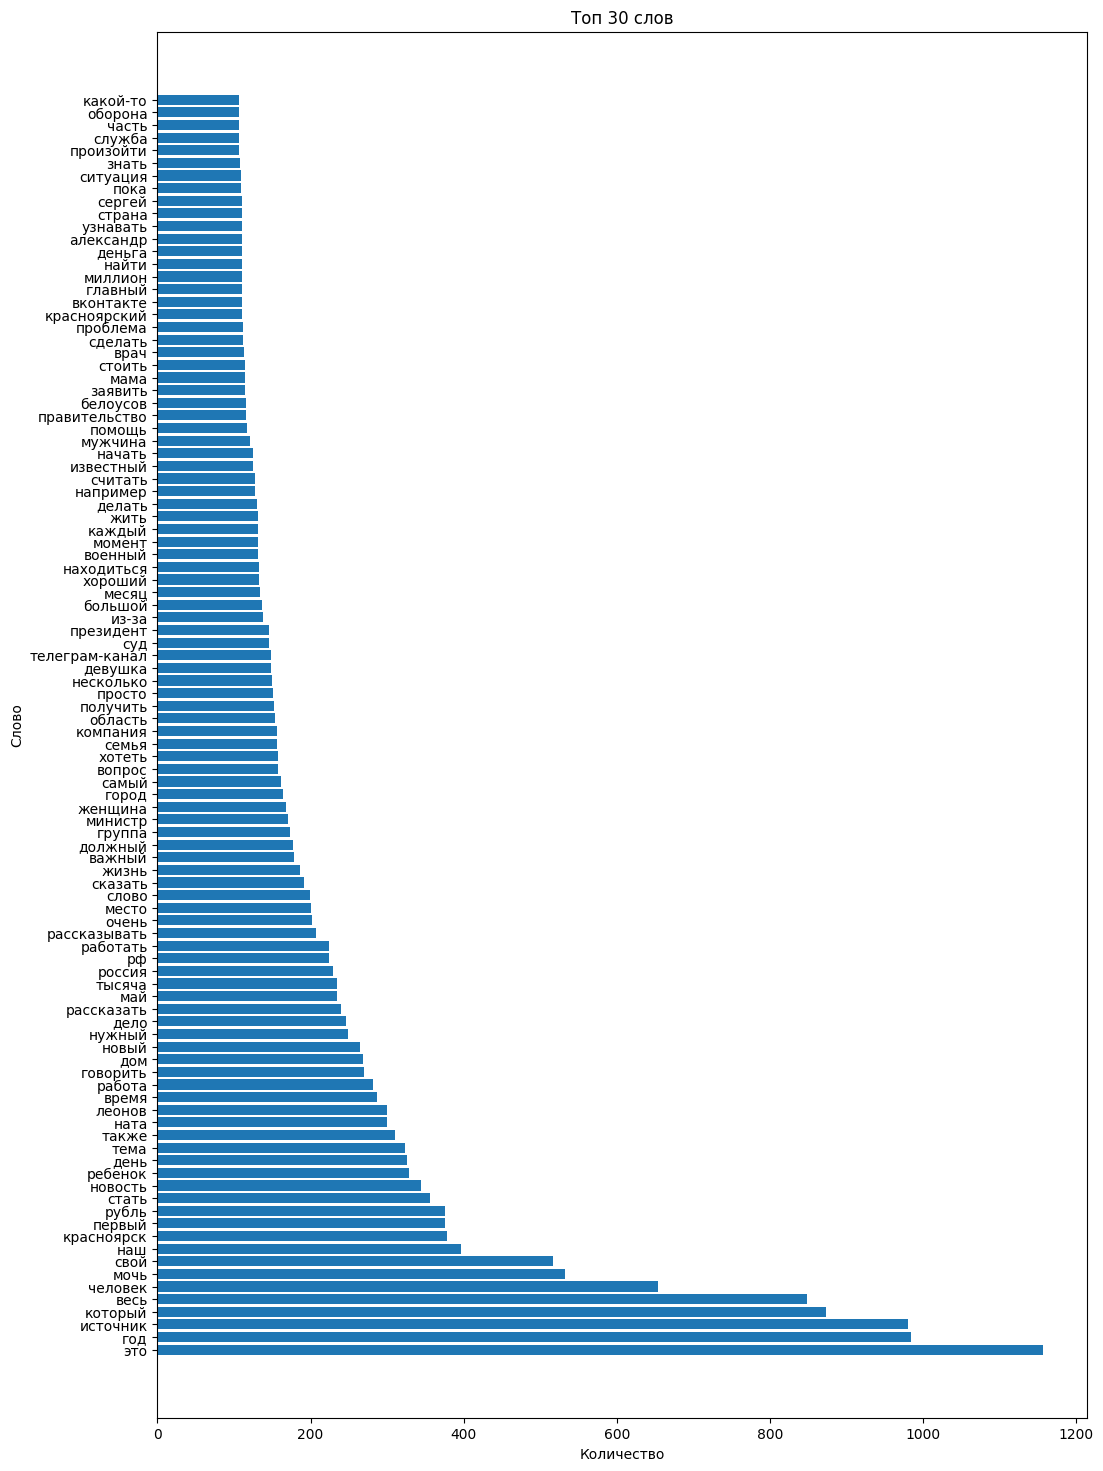

Word  Count
0         это   1157
1         год    985
2    источник    981
3     который    874
4        весь    849
..        ...    ...
95  произойти    107
96     служба    107
97      часть    107
98    оборона    107
99   какой-то    106

[100 rows x 2 columns]

In [16]:
df = DataFrame()
word = [i[0] for i in words_count.most_common(100)]
count = [i[1] for i in words_count.most_common(100)]

df["Word"] = word
df["Count"] = count
fig, ax = plt.subplots(figsize=(12, 18))

plt.barh(df["Word"], df["Count"])
plt.title("Топ 30 слов")
plt.ylabel("Слово")
plt.xlabel("Количество")
plt.show()

df